# Feature Contribution + Recourse Analysis
## California Housing Dataset
**Student SRN:** PES1UG23AM314

**Objective:** Perform feature contribution and recourse analysis using the California Housing Dataset from sklearn.

---
## Task 1: Load California Housing Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    mean_absolute_percentage_error, explained_variance_score,
    max_error, median_absolute_error
)
from xgboost import XGBRegressor
import shap
import dice_ml

print('All libraries imported successfully!')

All libraries imported successfully!


In [2]:
# Load the dataset
housing = fetch_california_housing(as_frame=True)
df = housing.frame

print(f'Dataset shape: {df.shape}')
print(f'Features: {list(housing.feature_names)}')
print(f'Target: MedHouseVal (Median House Value in $100,000s)')
print()
df.head()

Dataset shape: (20640, 9)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target: MedHouseVal (Median House Value in $100,000s)



,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [3]:
# Dataset statistics
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [4]:
# Check for missing values
print('Missing values per column:')
print(df.isnull().sum())
print(f'\nTotal missing values: {df.isnull().sum().sum()}')

Missing values per column:
MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

Total missing values: 0


In [5]:
# Split features and target
X = df.drop(columns=['MedHouseVal'])
y = df['MedHouseVal']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f'Training set: {X_train.shape[0]} samples')
print(f'Testing set:  {X_test.shape[0]} samples')

Training set: 16512 samples
Testing set:  4128 samples


---
## Task 2: Train XGBoost Regressor & Evaluation Metrics

In [6]:
# Train the XGBoost Regressor
model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)
model.fit(X_train, y_train)

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print('Model trained successfully!')

Model trained successfully!


In [7]:
# =============================================
# ALL EVALUATION METRICS
# =============================================

def compute_metrics(y_true, y_pred, dataset_name):
    """Compute all regression metrics."""
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    evs  = explained_variance_score(y_true, y_pred)
    me   = max_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    
    # Adjusted R² (for test set)
    n = len(y_true)
    p = X_train.shape[1]
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    return {
        'Dataset': dataset_name,
        'MSE': round(mse, 4),
        'RMSE': round(rmse, 4),
        'MAE': round(mae, 4),
        'Median AE': round(medae, 4),
        'R²': round(r2, 4),
        'Adjusted R²': round(adj_r2, 4),
        'MAPE (%)': round(mape * 100, 2),
        'Explained Variance': round(evs, 4),
        'Max Error': round(me, 4)
    }

train_metrics = compute_metrics(y_train, y_pred_train, 'Train')
test_metrics  = compute_metrics(y_test, y_pred_test, 'Test')

metrics_df = pd.DataFrame([train_metrics, test_metrics]).set_index('Dataset')
print('=' * 70)
print('MODEL EVALUATION METRICS')
print('=' * 70)
metrics_df.T

MODEL EVALUATION METRICS


Dataset,Train,Test
MSE,0.0713,0.2007
RMSE,0.2671,0.4480
MAE,0.1887,0.2937
Median AE,0.1345,0.1883
R²,0.9466,0.8468
Adjusted R²,0.9466,0.8465
MAPE (%),10.6700,17.1300
Explained Variance,0.9466,0.8469
Max Error,2.0119,3.1770


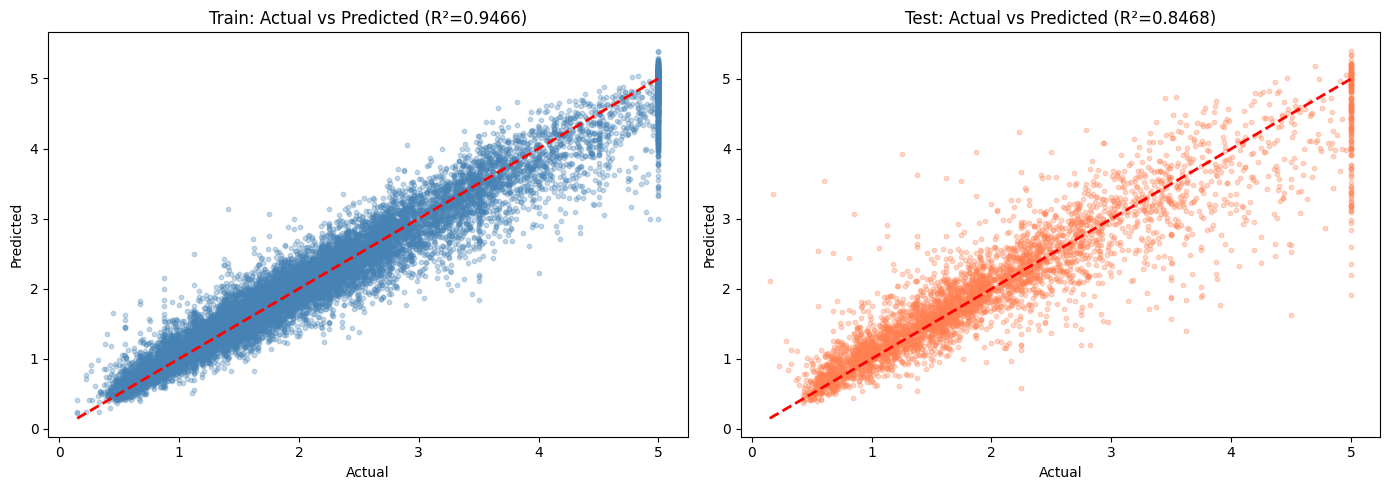

In [8]:
# Actual vs Predicted plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_train, y_pred_train, alpha=0.3, s=10, color='steelblue')
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title(f'Train: Actual vs Predicted (R²={train_metrics["R²"]})')

axes[1].scatter(y_test, y_pred_test, alpha=0.3, s=10, color='coral')
axes[1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].set_title(f'Test: Actual vs Predicted (R²={test_metrics["R²"]})')

plt.tight_layout()
plt.savefig('actual_vs_predicted.png', dpi=150)
plt.show()

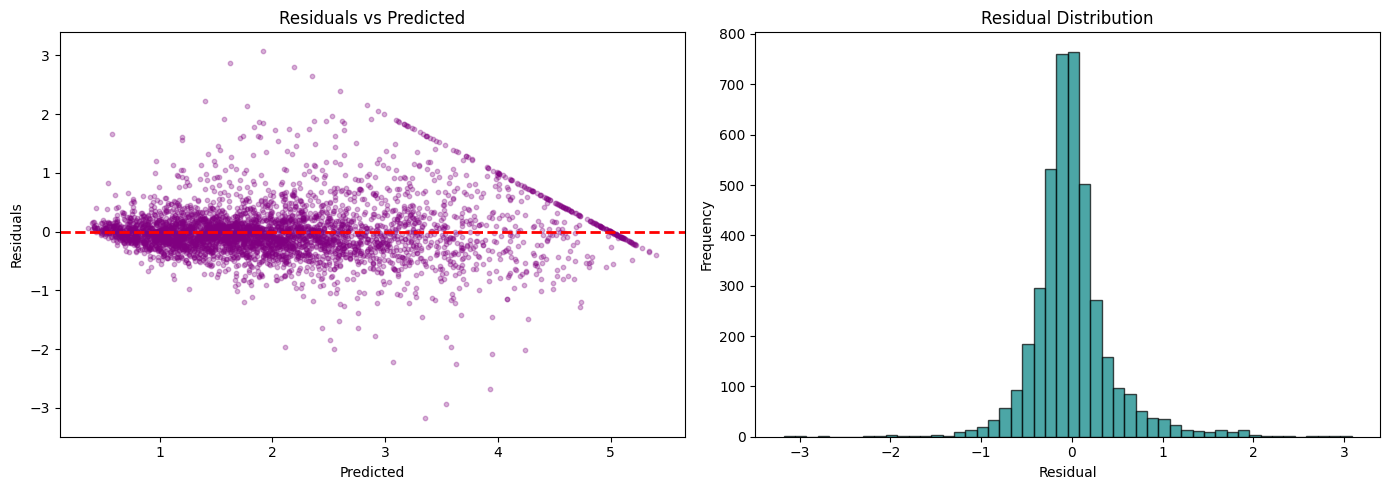

Mean Residual:   -0.0054
Std Residual:    0.4480


In [9]:
# Residual analysis
residuals = y_test - y_pred_test

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_pred_test, residuals, alpha=0.3, s=10, color='purple')
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Predicted')

axes[1].hist(residuals, bins=50, color='teal', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')

plt.tight_layout()
plt.savefig('residual_analysis.png', dpi=150)
plt.show()

print(f'Mean Residual:   {residuals.mean():.4f}')
print(f'Std Residual:    {residuals.std():.4f}')

---
## Task 3: SHAP Analysis

In [10]:
# Compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)
print('SHAP values computed successfully!')

SHAP values computed successfully!


### 3a) Global Feature Importance — `shap.plots.bar()`

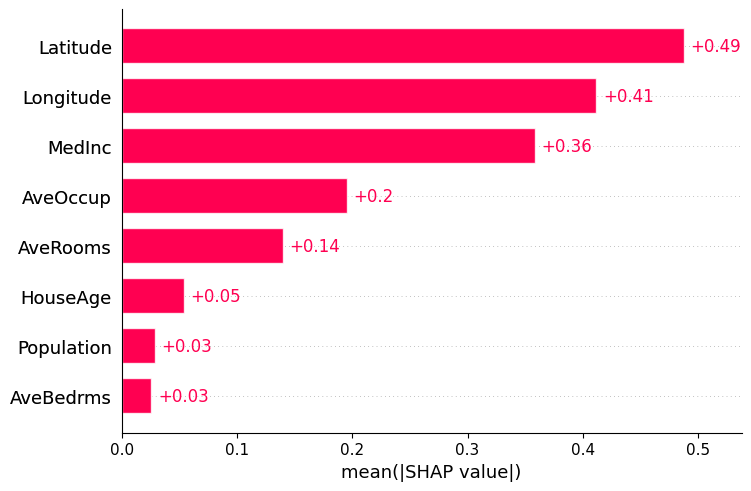

<Figure size 640x480 with 0 Axes>

In [11]:
shap.plots.bar(shap_values)
plt.savefig('shap_bar_plot.png', dpi=150, bbox_inches='tight')

### 3b) Summary Plot — `shap.summary_plot()`

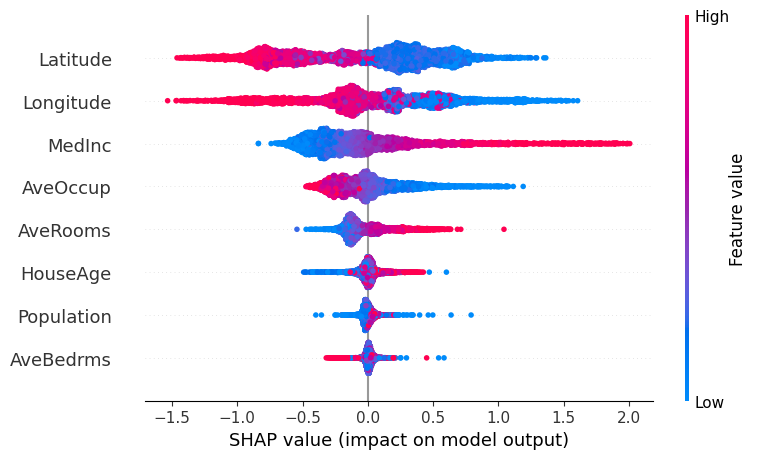

<Figure size 640x480 with 0 Axes>

In [12]:
shap.summary_plot(shap_values, X_test)
plt.savefig('shap_summary_plot.png', dpi=150, bbox_inches='tight')

### 3c) Local Explanation — `shap.plots.waterfall()`

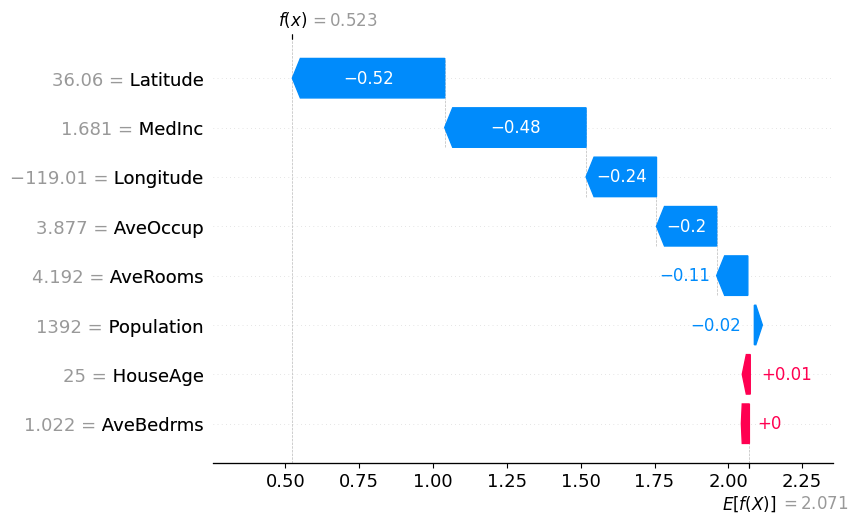

<Figure size 640x480 with 0 Axes>

In [13]:
# Waterfall plot for test instance 0
shap.plots.waterfall(shap_values[0])
plt.savefig('shap_waterfall_plot.png', dpi=150, bbox_inches='tight')

In [14]:
# SHAP Feature Importance Table
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_importance = pd.DataFrame({
    'Feature': X.columns,
    'Mean |SHAP|': mean_abs_shap
}).sort_values('Mean |SHAP|', ascending=False).reset_index(drop=True)

print('SHAP Feature Importance Rankings:')
shap_importance

SHAP Feature Importance Rankings:


,Feature,Mean |SHAP|
0,Latitude,0.487588
1,Longitude,0.411760
2,MedInc,0.358277
3,AveOccup,0.195406
4,AveRooms,0.140003
5,HouseAge,0.054189
6,Population,0.028988
7,AveBedrms,0.025926


---
## Task 4: Counterfactual Explanations using DiCE

In [15]:
# Prepare DiCE objects
train_df = X_train.copy()
train_df['MedHouseVal'] = y_train.values

dice_data = dice_ml.Data(
    dataframe=train_df,
    continuous_features=list(X.columns),
    outcome_name='MedHouseVal'
)

dice_model = dice_ml.Model(model=model, backend='sklearn', model_type='regressor')

# Using 'kdtree' method for reliable counterfactual generation
dice_exp = dice_ml.Dice(dice_data, dice_model, method='kdtree')

# Query instance
query_instance = X_test.iloc[[0]]
original_pred = model.predict(query_instance)[0]
print(f'Query instance (test sample 0):')
display(query_instance)
print(f'\nOriginal predicted price: ${original_pred * 100000:,.0f} (raw: {original_pred:.4f})')

Query instance (test sample 0):


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
20046,1.6812,25.0,4.192201,1.022284,1392.0,3.877437,36.06,-119.01



Original predicted price: $52,345 (raw: 0.5234)


### 4a) Increase Predicted House Price

In [16]:
desired_range_up = [original_pred + 0.5, original_pred + 2.0]
print(f'Desired range: [{desired_range_up[0]:.4f}, {desired_range_up[1]:.4f}]')

cf_increase = dice_exp.generate_counterfactuals(
    query_instance,
    total_CFs=3,
    desired_range=desired_range_up
)

print('\nCounterfactuals to INCREASE house price:')
cf_increase.visualize_as_dataframe(show_only_changes=True)

Desired range: [1.0234, 2.5234]


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


Counterfactuals to INCREASE house price:
Query instance (original outcome : 0.5234485268592834)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,1.6812,25.0,4.192201,1.022284,1392.0,3.877437,36.060001,-119.010002,0.523449



Diverse Counterfactual set (new outcome: [np.float32(1.0234485), np.float32(2.5234485)])


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
17448,3.792,23.0,5.6,1.1,-,3.2,34.63,-120.5,1.6761983633041382
14747,4.087,23.0,5.6,1.0,-,4.1,32.58,-117.1,1.357759714126587
14663,3.872,29.0,5.5,1.0,-,2.7,32.8,-117.1,1.5513955354690552


### 4b) Reduce Predicted House Price

In [17]:
desired_range_down = [max(0.15, original_pred - 2.0), max(0.5, original_pred - 0.5)]
print(f'Desired range: [{desired_range_down[0]:.4f}, {desired_range_down[1]:.4f}]')

cf_decrease = dice_exp.generate_counterfactuals(
    query_instance,
    total_CFs=3,
    desired_range=desired_range_down
)

print('\nCounterfactuals to DECREASE house price:')
cf_decrease.visualize_as_dataframe(show_only_changes=True)

Desired range: [0.1500, 0.5000]


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


Counterfactuals to DECREASE house price:
Query instance (original outcome : 0.5234485268592834)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,1.6812,25.0,4.192201,1.022284,1392.0,3.877437,36.060001,-119.010002,0.523449



Diverse Counterfactual set (new outcome: [0.15, 0.5])


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
20003,1.909,29.0,5.4,1.1,-,4.2,-,-,0.4936140179634094
3250,2.098,-,3.7,0.9,-,5.3,-,-,0.46723759174346924
2925,1.68,38.0,4.9,1.0,-,3.2,35.36,-,0.4721486270427704


---
## Task 5: Experimental What-If Studies

In [18]:
# For What-If studies we use the 'random' method which supports
# features_to_vary and permitted_range constraints
dice_exp_random = dice_ml.Dice(dice_data, dice_model, method='random')

### 5a) Actionable Counterfactual
**Constraint:** Allow change only in `income` and `house age`

In [19]:
features_to_vary = ['MedInc', 'HouseAge']
permitted_range = {
    'MedInc': [0.5, 15.0],     # realistic income range
    'HouseAge': [1.0, 52.0]    # realistic house age range
}

print(f'Features allowed to change: {features_to_vary}')
print(f'Permitted ranges: {permitted_range}')

cf_actionable = dice_exp_random.generate_counterfactuals(
    query_instance,
    total_CFs=3,
    desired_range=[original_pred + 0.5, original_pred + 2.0],
    features_to_vary=features_to_vary,
    permitted_range=permitted_range,
    random_seed=42
)

print('\nActionable Counterfactuals (only MedInc & HouseAge change):')
cf_actionable.visualize_as_dataframe(show_only_changes=True)

Features allowed to change: ['MedInc', 'HouseAge']
Permitted ranges: {'MedInc': [0.5, 15.0], 'HouseAge': [1.0, 52.0]}


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Actionable Counterfactuals (only MedInc & HouseAge change):
Query instance (original outcome : 1.0)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,1.6812,25.0,4.192201,1.022284,1392.0,3.877437,36.060001,-119.010002,1.0



Diverse Counterfactual set (new outcome: [np.float32(1.0234485), np.float32(2.5234485)])


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,14.494,50.3,-,-,-,-,-,-,2.0416245460510254
1,5.694,-,-,-,-,-,-,-,1.2178020477294922
2,7.477,25.6,-,-,-,-,-,-,1.6830146312713623


### 5b) Realistic Constraint Counterfactual
**Constraint:** Fix `latitude` and `longitude` (location cannot change)

In [20]:
features_to_vary_geo = [f for f in X.columns if f not in ['Latitude', 'Longitude']]
print(f'Features allowed to vary: {features_to_vary_geo}')
print(f'Fixed features: Latitude, Longitude')

cf_realistic = dice_exp_random.generate_counterfactuals(
    query_instance,
    total_CFs=3,
    desired_range=[original_pred + 0.5, original_pred + 2.0],
    features_to_vary=features_to_vary_geo,
    random_seed=42
)

print('\nRealistic Counterfactuals (Latitude & Longitude fixed):')
cf_realistic.visualize_as_dataframe(show_only_changes=True)

Features allowed to vary: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']
Fixed features: Latitude, Longitude


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


Realistic Counterfactuals (Latitude & Longitude fixed):
Query instance (original outcome : 1.0)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,1.6812,25.0,4.192201,1.022284,1392.0,3.877437,36.060001,-119.010002,1.0



Diverse Counterfactual set (new outcome: [np.float32(1.0234485), np.float32(2.5234485)])


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,13.629,-,-,-,-,-,-,-,2.063950538635254
1,-,-,100.6,-,-,878.4,-,-,1.473661184310913
2,6.26,-,-,-,14174.2,-,-,-,1.2124671936035156


---
## Observations & Analysis

### Observation 1: SHAP Importance ≠ Counterfactual Change

**MedInc** (Median Income) is the most important feature by SHAP (highest mean |SHAP value|). However, in the actionable counterfactual (5a), changing MedInc alone is sometimes not enough to achieve the desired price increase — HouseAge must also shift. This shows that **SHAP importance** (marginal contribution) **doesn't directly translate to counterfactual actionability**. A feature can be globally important yet require coupled changes with other features to move predictions meaningfully for a specific instance.

### Observation 2: Surprising Feature Behaviour

From the SHAP summary plot, **AveOccup** (average occupancy) shows a surprising non-linear behaviour: very low values push predictions **UP** (red dots on positive SHAP side), while moderate-to-high values have near-zero or slightly negative SHAP. Intuitively, fewer occupants per household signals wealthier / less crowded areas, but the effect is disproportionately strong at the low end, suggesting the model captures a **threshold effect** rather than a smooth linear relationship.

### Observation 3: Model Bias Observation

The model exhibits **geographic bias** — Latitude and Longitude are among the top SHAP features, meaning the model heavily relies on location to predict house prices. Coastal areas (lower longitude, specific latitude bands near SF/LA) systematically get higher predictions. When we fix Latitude & Longitude in the realistic constraint counterfactual (5b), the model needs **much larger changes** in other features to achieve the same price increase, confirming the model has baked in location-based bias that may disadvantage inland communities regardless of other housing quality factors.